(C) Gerold Baier, University College London, 2024

# Machine Learning 1 – Classification

Classification is one type of Machine Learning. It belongs to the _supervised_ learning methods. 

In Supervised Machine Learning we deal with labelled data. Labelled data are any type of data with at least one extra column of a categorical label for each sample. For a minimum of two labels, a machine learning model can be trained to learn the categories from the provided labelled examples. 

Examples of labels include 'control group / test group'; 'male / female / other'; 'healthy / diseased'; 'before treatment / after treatment'. Here we use 0 and 1 to represent the classes. 

The task in Supervised Machine Learning is to fit (train) a model to an exemplary data set to then be able to work as a _predictor_ and successfully categorise new incoming data. The more generalisable the model fit, the better the labelling (predictions).


In [36]:
from numpy import pi, linspace, sin, diff, arange, asarray, zeros, exp, array, linspace, median, gradient, around
from numpy import zeros_like, triu_indices, triu_indices_from, tril_indices, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import count_nonzero

from matplotlib.pyplot import xlabel, ylabel, hist, bar, yticks, legend, axis, figure, xticks, gca, show

from scipy.signal import butter, sosfilt
from scipy.stats import spearmanr, kendalltau

from matplotlib.pyplot import subplots, figure

from pandas import read_csv

import networkx as nx

from matplotlib.pyplot import subplots, xticks, yticks, axis, sca
from numpy import arange, corrcoef, fill_diagonal, zeros, linspace, argsort
from numpy import amax, gradient, array, asarray, flip, concatenate, around
from pandas import read_csv

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


Let us first read the data, see an EEG plot and get the correlation matrices foor the first third of the segment (where there is no visible seizure activity) and the final third (where there is visible seizure activity).


In [12]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start = 0
    samples = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means   = data[start:start+samples, :electrodes].mean(axis=0)
    devs    = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(11, 10))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    yticks([]);

    axis('tight');

    return fig, ax


In [13]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '1'         # '1'
seizure     = '03'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' 

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_100Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

print('')
print(series_chars)
print('')


../Data/Pat1_Sz03_Onset_1_100Hz.csv



In [14]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'A': [0, 11],
 'B': [11, 22],
 'C': [22, 31],
 'E': [31, 40],
 'F': [40, 49],
 'Z': [49, 56],
 'O': [56, 67],
 'T': [67, 74],
 'U': [74, 81],
 'V': [81, 92],
 'W': [92, 107],
 'X': [107, 122]}

In [15]:
onset  = (146.7, 147.0, 146.7)


In [16]:
time_max = 60

init_cut  = 25

band_low  = 1
band_high = 100

order = 5

rows_max = int(time_max * sr)

sample_start = int((onset[int(seizure)-1]-30)*sr)
# sample_start = 0

sample_end = sample_start + rows_max

channel_start, channel_stop = 0, data_prefiltered.shape[1]  # Bad channels 81, 82 for 2015lvxiaofu

number_channels = channel_stop - channel_start


data_unfiltered = data_prefiltered[:, channel_start:channel_stop]


sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_unfiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(60000, 122)

## Complete EEG

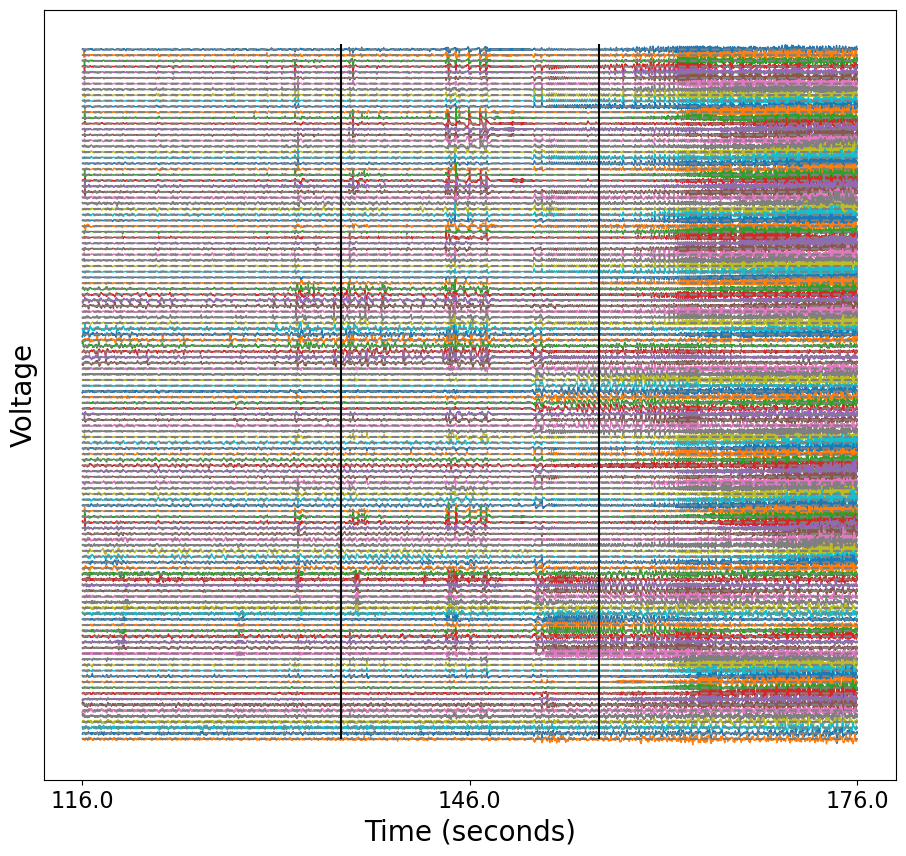

In [17]:
stretch_factor = 5

fig, ax = eeg_plot(data_filtered, stretch_factor)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

ax.set_ylabel('Voltage', fontsize=20);

ax.vlines(rows_max//3,   0, stretch_factor*number_channels, color='k');
ax.vlines(2*rows_max//3, 0, stretch_factor*number_channels, color='k');

show()


The vertical lines separate the three thirds of the data set.

Here are the correlation matrices of the first and last third of data.


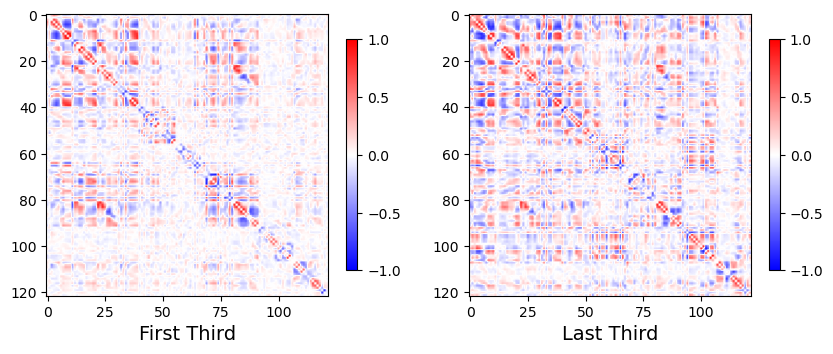

In [18]:
data_corr_before = corrcoef(data_filtered[:1*rows_max//3, :], rowvar=False)
data_corr_after  = corrcoef(data_filtered[2*rows_max//3:, :], rowvar=False)

fill_diagonal(data_corr_before, 0)
fill_diagonal(data_corr_after,  0)

fig, ax = subplots(figsize=(10,10), ncols=2)

im = ax[0].imshow(data_corr_before, cmap='bwr', vmin=-1, vmax=1)
ax[0].set_xlabel('First Third', fontsize=14)
fig.colorbar(im, ax=ax[0], shrink=0.3, ticks=[-1., -0.5, 0, 0.5, 1.]);

im = ax[1].imshow(data_corr_after, cmap='bwr', vmin=-1, vmax=1)
fig.colorbar(im, ax=ax[1], shrink=0.3, ticks=[-1., -0.5, 0, 0.5, 1.]);
ax[1].set_xlabel('Last Third', fontsize=14);


## Prepare Training Data

The terminology that is widely used in Machine Learning refers to data points as __samples__, and the different types of recordings (columns in our case) are referred to as __features__. In `numpy` notation, samples are organised in rows, features in columns.

The convention in Machine Learning is to call the training data __X__. This array must be __two dimensional__, where rows are the samples and columns are the features.

Let us start by using the first 30 channels to train a classifier.


In [19]:
channel_start  = 0
channel_number = 60
channels       = array(arange(channel_start, channel_start+channel_number))
channel_names  = all_labels[channel_start:channel_start+channel_number]

X_before = data_filtered[:1*rows_max//3, channels]
X_after  = data_filtered[2*rows_max//3:, channels]

X = concatenate((X_before, X_after), axis=0)

print(X.shape)


(40000, 60)


## Prepare Labels

The array of labels is called __y__. It must have the same number of elements as there are rows in __X__. In our case, the first half of rows in __X__, and thus the first half of __y__, is labelled '0' (non-seizure), the second half '1' (seizure).


In [20]:
y  = zeros(X.shape[0])

y[X.shape[0]//2:] = 1

print(y.shape)


(40000,)


We can check this by plotting the first ten data points and labels, and the last ten data points and labels.


In [21]:
print(X[:10, 0])
print(y[:10])

print(X[-10:, 0])
print(y[-10:])


[18.75560177 19.72944391 20.52366651 21.11278619 21.54246683 21.90786543
 22.3175987  22.85759797 23.56655781 24.42855742]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.15196961 -1.31693399 -1.31019869 -1.14131383 -0.85678671 -0.53743711
 -0.26834437 -0.09884676 -0.02356254 -0.00269163]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Scikit Learn Classifiers

We import some machine learning functionality from the [SciKit Learn library](https://scikit-learn.org/stable/).

> __SciKit Learn__ is a renowned open source application programming interface (API) for machine learning. It enjoys a vibrant community and is extremely well-maintained. SciKit Learn provides an exceptional documentation with detailed explanations and examples at every level.

Different classification algorithms approach problems differently. Let us see some of the algorithms in SciKit Learn.

SciKit Learn provides the following algorithms for classification problems:

- Ensemble: Averaging:
    - Random Forest 
    - Extra Tree 
    - Isolation Forest 
    - Bagging
    - Voting 
   
- Boosting:
    - Gradient Boosting 
    - AdaBoost
    
- Decision Trees: 
    - Decision Tree 
    - Extra Tree
  
- Nearest Neighbour: 
    - K Nearest Neighbour 
    - Radius Neighbours 
    - Nearest Centroid
    
- Support Vector Machine: 
    - with non-linear kernel:
        - Radial Basis Function (RBF) Polynomial
        - Sigmoid
    - with linear kernel: 
        - Linear kernel
    - parametrised with non-linear kernel: 
        - Nu-Support Vector Classification
        
- Neural Networks: 
    - Multi-layer Perceptron
    - Gaussian: 
        - Gaussian Process
    - Linear Models: 
        - Logistic Regression
        - Passive Aggressive
        - Ridge
        - Linear classifiers with Stochastic Gradient Descent

- Baysian: 
    - Bernoulli 
    - Multinomial 
    - Complement
        
Some of these algorithms require a more in-depth understanding of how they work. To that end, we would only review the performance the ones that are easier to implement and adjust. 

You can read more here: https://www.geeksforgeeks.org/comprehensive-guide-to-classification-models-in-scikit-learn/ 

__Seeding__

Most machine learning algorithms rely on random number generation to produce results. Therefore, one simple, but important adjustment is to `seed` the number generator, and thereby making our comparisons more consistent; i.e. ensure that all models use the same set of random numbers. Almost all SciKit Learn models take an argument called `random_state`, which takes an integer number and uses it to seed the random number generator.


Let us import some classifiers and compare their performance. 


In [38]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

RANDOM_STATE = 123

classifiers = {
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Extra Trees': ExtraTreesClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'SVC (RBF)': SVC(random_state=RANDOM_STATE),
    'SVC (Linear)': LinearSVC(random_state=RANDOM_STATE),
    'Multi-layer Perceptron': MLPClassifier(max_iter=5000, random_state=RANDOM_STATE)
}


## The Train-Test Split

In our array __X__ we have a data set of n labelled samples. Of these n samples a certain percentage will now be used for training (using the provided labels) and the rest will be kept for testing (predicting while withholding the labels).

The function we use is `train_test_split` from SciKit Learn. A nice feauture of this function is that it tries to preserve the ratio of labels in the split. E.g. if the data contain 50% of `True` and 50 % of `False` labels, the algorithm picks training data such that it preserves this ratio .

We then fit the models to the training data. The success of the training is calculated from the comparison of predictions with the (withheld) true labels. 

As a result we print the score of each of the classifiers.


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=.5, 
                                   random_state=RANDOM_STATE, 
                                   shuffle=True)

scores = list()
name_list = list()

for name, clf in classifiers.items():
    # Training the model using training data:     
    clf.fit(X_train, y_train)

    # Predict test data
    y_pred = clf.predict(X_test)

    # Evaluating the score using test data:
    score = clf.score(X_test, y_test)
    
    # Results
    scores.append(score)
    name_list.append(name)
    print(name, score)

print('')
print('Complete')
print('')


Random Forest 0.99995
Extra Trees 1.0
Decision Tree 0.99645
SVC (RBF) 0.9966


/Users/geroldbaier/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/geroldbaier/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC (Linear) 0.64695
Multi-layer Perceptron 0.99885

Complete



The classic way of evaluating the performance of a classifier uses the __Receiver Operation Characteristic (ROC)__ and the __Area Under the Curve (AUC)__.

A receiver operation characteristic, often referred to as the __ROC curve__, is a visualisation of the discrimination threshold in a binary classification model. It illustrates the rate of true positives (TPR) against the rate of false positives (FPR) at different thresholds. The aforementioned rates are essentially defined as:

- True Positive Rate (TPR): the sensitivity of the model
- False Positive Rate (FPR): one minus the specificity of the model

The area under the ROC curve, often referred to as AUC, reduces the information contained within a ROC curve down to a value between 0 and 1, with 1 being a perfect fit. An AUC value of 0.5 represents a random guess.


/Users/geroldbaier/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/geroldbaier/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


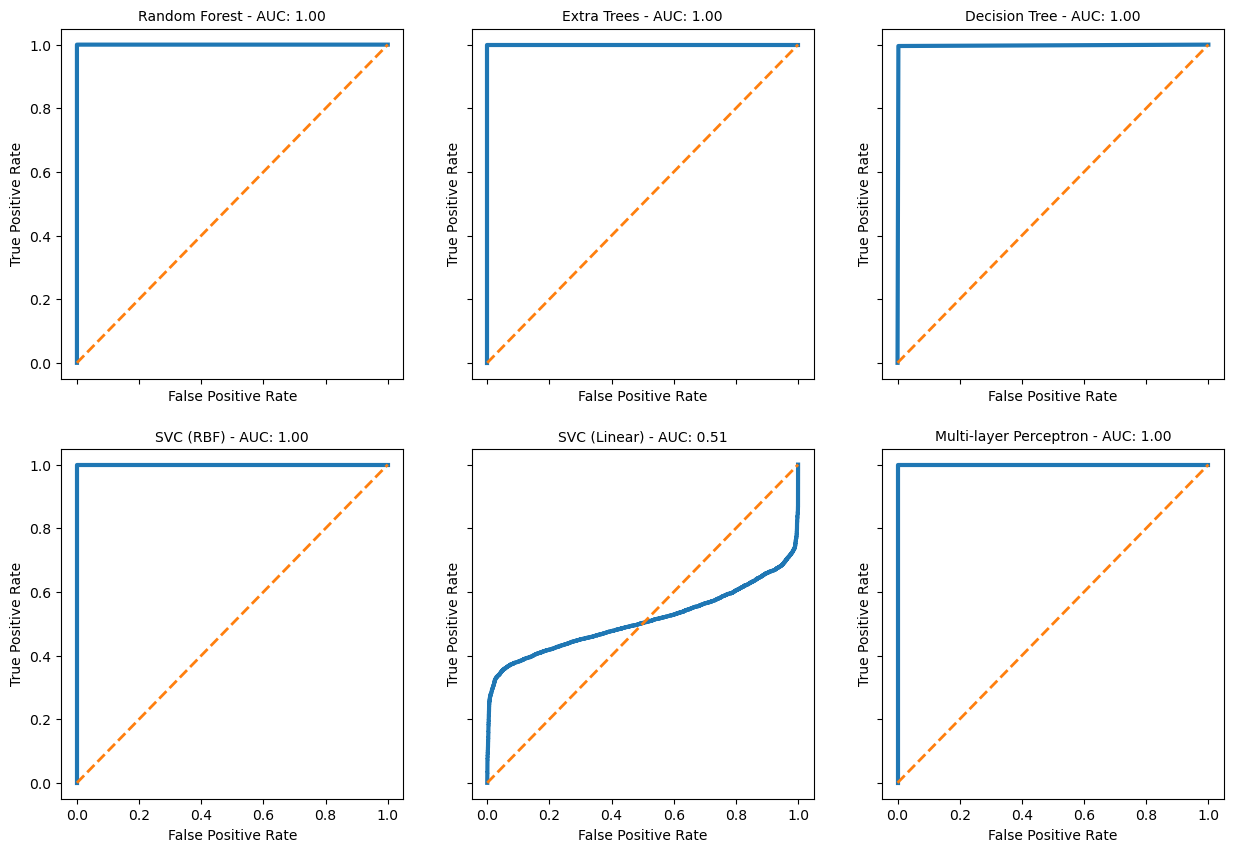

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, all_axes = subplots(figsize=[15, 10], ncols=3, nrows=2, sharey=True, sharex=True)

for ax, (name, clf) in zip(all_axes.ravel(), classifiers.items()):
    clf.fit(X_train, y_train)

    # Checking whether or not the object has `decision_function`:
    if hasattr(clf, 'decision_function'):
        # If it does:
        y_score = clf.decision_function(X_test)
    else:
        # Otherwise:
        y_score = clf.predict_proba(X_test)[:, 1] # only one probability is needed

    # Obtaining the x- and y-axis values for the ROC curve:
    fpr, tpr, thresh = roc_curve(y_test, y_score)

    # Obtaining the AUC value: 
    roc_auc = roc_auc_score(y_test, y_score)

    ax.plot(fpr, tpr, lw=3)
    ax.plot([0, 1], [0, 1], lw=2, linestyle='--')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    label = '{} - AUC: {:.2f}'.format(name, roc_auc)
    ax.set_title(label, fontsize=10)
    
show()


We see that the ensemble classifiers, the support vector classifier with radial basis functions, and the neural network (perceptron) make perfect or nearly perfect predictions after the training. The SVC with linear basis function fails to make predictions that are above chance level. 


## The Random Forest Classifier

The Random Forest is a member of the ensemble learning family based , whose objective is to combine the predictions of several optimisations to improve their performance, generalisability, and robustness. 

Here is a more extended description on how the algorithm works: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/ )

Let us train the Random Forest classifier with all sEEG channels.

In [41]:
channel_start  = 0
channel_number = data_filtered.shape[1]

channels       = array(arange(channel_start, channel_start+channel_number))
channel_names  = all_labels[channel_start:channel_start+channel_number]


X_before = data_filtered[:1*rows_max//3, channels]
X_after  = data_filtered[2*rows_max//3:, channels]

X = concatenate((X_before, X_after), axis=0)

print(X.shape)

(40000, 122)


In [42]:
RANDOM_STATE = 111

clf_RF = RandomForestClassifier(random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=.5, 
                                   random_state=RANDOM_STATE, 
                                   shuffle=True)

clf_RF.fit(X_train, y_train)


RandomForestClassifier(random_state=111)

This classifier is now ready to be used for predictions. 


## Random Forest predictions

Let us now use the trained model and predict the intermediate data in terms of non-seizure vs. seizure. 


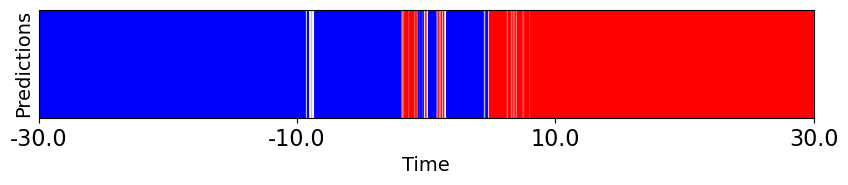

In [43]:
predictions_RF = clf_RF.predict(data_filtered[:, channels])

predict_RF = predictions_RF.reshape(-1, 1)

time = rows_max//sr

fig, ax = subplots(figsize=(10,1.4))

ax.imshow(predict_RF.transpose(), cmap='bwr', aspect='auto')
ax.set_xticks(linspace(0, rows_max, 4))
labl = linspace(- time/2, time/2, 4)
ax.set_xticklabels(around(labl, 1), fontsize=16)
ax.set_xlabel('Time', fontsize=14) 
ax.set_ylabel('Predictions', fontsize=14)
ax.set_yticks([])
ax.set_yticklabels([]);

show()

#fig.savefig('Long_predictions.png', format='png')

Zoom in

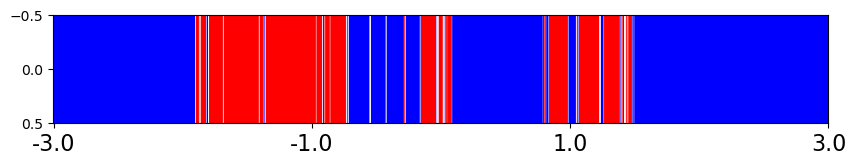

In [44]:
fig, ax = subplots(figsize=(10,1.4))

start, stop = 27000, 33000

ax.imshow(predict_RF[start:stop].T, cmap='bwr', aspect='auto');
ax.set_xticks(linspace(0, stop-start, 4))
labl = linspace(start//sr - time/2, stop//sr - time/2, 4)
ax.set_xticklabels(around(labl, 1), fontsize=16)

show()


The blue first and the red third part of the time series represent the training data. The middle third is where the trained model predicts whether a sample is seizure or not.


## Random Forest: Probabilities

The above predictions were simple 0 or 1 labels. However, the model also lets us see the probability of a prediction. These probabilities are numeric values between 0 and 1. 


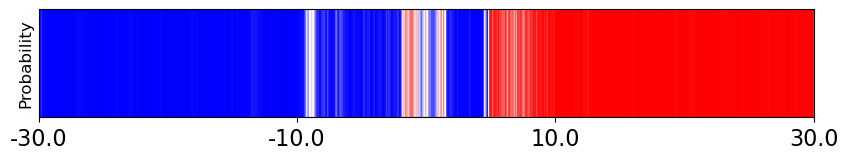

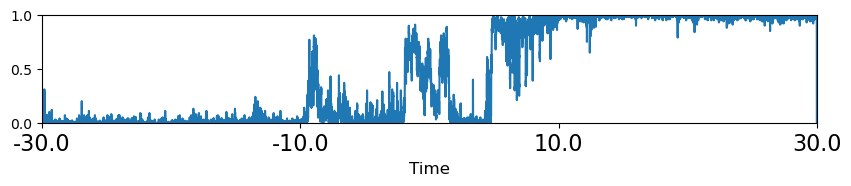

In [45]:
probab_RF = clf_RF.predict_proba(data_filtered[:,channels])

probab_RF = probab_RF[:, 1].reshape(-1,1)

fig, ax = subplots(figsize=(10,1.4))

ax.imshow(probab_RF.transpose(), cmap='bwr', aspect='auto')
ax.set_yticks([])
ax.set_yticklabels([]);
ax.set_xticks(linspace(0, rows_max, 4))
labl = linspace(- time/2, time/2, 4)
ax.set_xticklabels(around(labl, 1), fontsize=16)
ax.set_ylabel('Probability', fontsize=12)
ax.set_yticks([])
ax.set_yticklabels([]);

fig, ax = subplots(figsize=(10,1.4))
ax.plot(probab_RF)
ax.margins(0)
ax.set_xticks(linspace(0, rows_max, 4))
labl = linspace(- time/2, time/2, 4)
ax.set_xticklabels(around(labl, 1), fontsize=16);
ax.set_xlabel('Time', fontsize=12);

show()


The middle interval of our segment shows different phases of predictions. Chance level is at 0.5 or 50%.


## Feature Importances

We can check the contribution of each feature for the success of the classification. The feature importance is given as the fraction contribution of each feature to the prediction.


Relative feature importance:


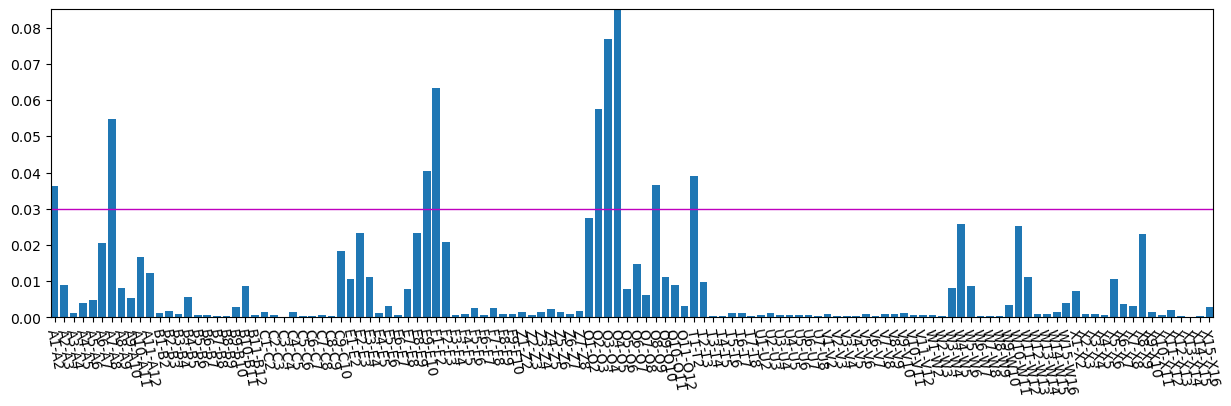

In [46]:
importances = clf_RF.feature_importances_

print('Relative feature importance:')

bins = arange(importances.shape[0])

fig, ax = subplots(figsize=(15,4))

ax.bar(bins, importances);
ax.set_xticks(bins)
ax.set_xticklabels(channel_names, rotation=-80, fontsize=10);

importance_threshold = 0.03

ax.axhline(y=importance_threshold, linewidth=1, color='m');
ax.margins(0)

show()


The individual channels contribute differently to the prediction. Feature importances are thus a valuable way to assess the involvement of channels in seizure onset.


When we see the feature importances we can see the channels that contribute most to the prediction. Given the unequal distribution, we can speed up the process by picking the channels with the highest importance and use them to redo the training. 

## Best performing channels only

In [48]:
RF_best = importances > importance_threshold

X_best  = X[:, RF_best]

X_best.shape


(40000, 9)

In [49]:
RANDOM_STATE = 111

clf_RF_best = RandomForestClassifier(random_state=RANDOM_STATE)

clf_RF_best.fit(X_best, y)


predictions_RF_best = clf_RF_best.predict(data_filtered[:, RF_best])

predict_RF_best = predictions_RF_best.reshape(-1, 1)

probab_RF_best = clf_RF_best.predict_proba(data_filtered[:, RF_best])

probab_RF_best = probab_RF_best[:, 1].reshape(-1,1)


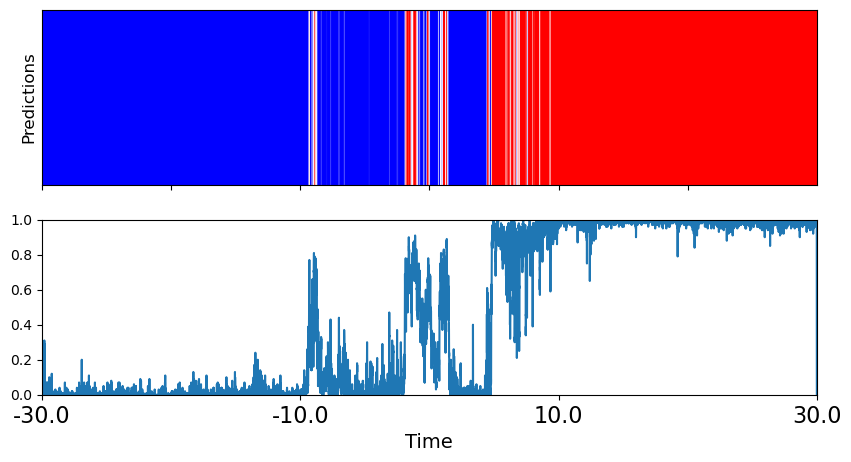

In [50]:
fig, ax = subplots(figsize=(10, 5), nrows=2)

ax[0].imshow(predict_RF_best.transpose(), cmap='bwr', aspect='auto')

ax[0].set_ylabel('Predictions', fontsize=12) 
ax[0].set_yticks([])
ax[0].set_yticklabels([]);
ax[0].set_xticklabels([]);

ax[1].plot(probab_RF)
ax[1].margins(0)
ax[1].set_xticks(linspace(0, rows_max, 4))
labl = linspace(- time/2, time/2, 4)
ax[1].set_xticklabels(around(labl, 1), fontsize=16);
ax[1].set_xlabel('Time', fontsize=14);

show()


There is now some evidence of pending seizure onset in the middle third of the data based on training with only thirteen channels. But it is not enough to be able to predict that there will be a seizure. Typically, seizures are not predictable by EEG analysis alone. 


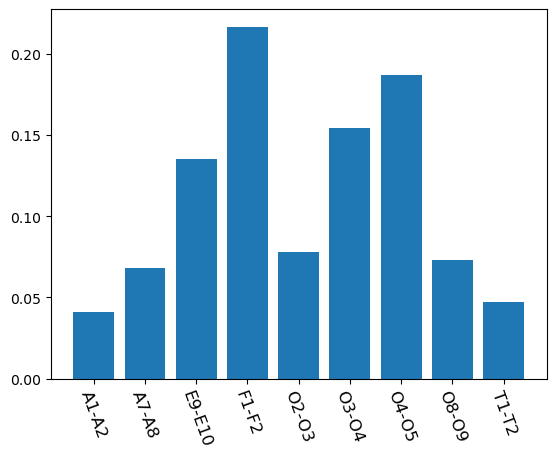

In [51]:
importances_best = clf_RF_best.feature_importances_

channel_names_best = asarray(channel_names)[RF_best]

bins = arange(importances_best.shape[0])

fig, ax = subplots()

ax.bar(bins, importances_best);
ax.set_xticks(bins)
ax.set_xticklabels(channel_names_best, rotation=-70, fontsize=12);

# importance_threshold = 0.03
# ax.axhline(y=importance_threshold, linewidth=1, color='m');

show()


These are the best channels that allow the Random Forest algorithm to best distinguish between non-seizure and seizure state. We see that the result contains several series from the __X__ electrode. This is not necessarily the electrode one would have picked from visual inspection. Note that these channels were selected by the model based on multivariate properties, i.e. interrelationships between the channels. 


## Comparison with a Correlation Matrix predictor

We can compare the result to the channels that show the biggest change in (Pearson) overall correlation between non-seizure and seizure state (i.e. comparing the correlations in the first and third segment).

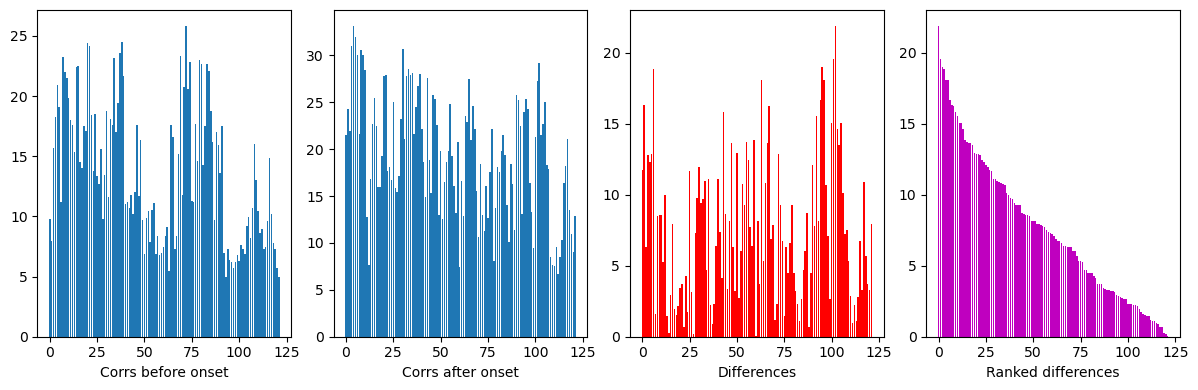

In [52]:
data_corr_before_sum = sum(abs(data_corr_before))
data_corr_after_sum  = sum(abs(data_corr_after))
data_corr_diff = data_corr_after_sum - data_corr_before_sum

data_corr_diff_abs = abs(data_corr_diff)

diff_indices_abs = argsort(-data_corr_diff_abs)
    
diffs_abs_ranked = data_corr_diff_abs[diff_indices_abs]

fig, ax = subplots(ncols=4, figsize=(12,4))

bins = arange(len(data_corr_before_sum))
ax[0].bar(bins, data_corr_before_sum)
ax[1].bar(bins, data_corr_after_sum)
ax[2].bar(bins, data_corr_diff_abs, color='r');
ax[3].bar(bins, diffs_abs_ranked,   color='m');

ax[0].set_xlabel('Corrs before onset')
ax[1].set_xlabel('Corrs after onset')
ax[2].set_xlabel('Differences')
ax[3].set_xlabel('Ranked differences')

fig.tight_layout()

show()


In [53]:
data_corr_diff_best_channels = asarray(channel_names)[diff_indices_abs[:X_best.shape[1]]]


print('Comparison of Correlation and Classification Channels')
print('')
print('Random Forest:', channel_names_best)
print('')
print('Correlations: ', list(data_corr_diff_best_channels))
print('')


Comparison of Correlation and Classification Channels

Random Forest: ['A1-A2' 'A7-A8' 'E9-E10' 'F1-F2' 'O2-O3' 'O3-O4' 'O4-O5' 'O8-O9' 'T1-T2']

Correlations:  ['W11-W12', 'W10-W11', 'W4-W5', 'A7-A8', 'W5-W6', 'O8-O9', 'W3-W4', 'A2-A3', 'T1-T2']



There are a few coincidences of channels in the two sets. In particular, none of the "W" channels appears among the best features in the classification whereas they seem to show strong changes in correlations.  
But the rationale is different: classification works to catch information contained in the labels. Correlation only looks at time series similarity – independent of whether it has something to do with the epileptic seizure rhythm. 

Note that the Machine Learning algorithm works on samples: the prediction is made by the trained model based on just a single time point! In contrast, the correlation matrix was calculated over the entire interval of training data. 

This ends the introduction to Classification. Thanks to the consistency of __scikit-learn__ it is straightforward to use similar functionality for unsupervised Machine Learning.


# Conclusions

ML models like the Random Forest can easily be fitted to any data array. The train-test split allows a quantitative estimate of the quality of the predictor. In general, further improvement and refinement is needed before the model can be used for serious field predictions. 

# Try it yourself

Import another data set (with either seizure onset or offset) and use the trained predictor above to predict the complete data. What "seizure" instances can you find?
